#Загрузка и базовая предобработка изображений

In [1]:
# Импорт необходимых библиотек
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.applications.resnet50 import preprocess_input
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Параметры
IMG_SIZE = 128  # размер, к которому приводим все изображения
DATA_PATH = "/content/data"  # путь к распакованному датасету
CLASSES = ['amoeba', 'Leegaardiella_ovalis', 'Mesodinium_sp']

# Чтение и предобработка изображений
images = []
labels = []

for idx, label in enumerate(CLASSES):
    folder = os.path.join(DATA_PATH, label)
    for file_name in tqdm(os.listdir(folder), desc=f"Чтение {label}"):
        if not file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
        img_path = os.path.join(folder, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0  # нормализация
        images.append(img)
        labels.append(idx)

X = np.array(images)
y = np.array(labels)

Чтение Mesodinium_sp: 100%|██████████| 252/252 [00:00<00:00, 865.99it/s]


Приводятся к размеру 128x128;

Нормализуются к диапазону [0,1];

Записываются в массивы X (изображения) и y (метки классов);

#Фильтрация изображений


In [3]:
# Применение фильтрации (гауссов фильтр + CLAHE)
def apply_filters(img):
    blurred = cv2.GaussianBlur(img, (3, 3), 1)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    filtered = clahe.apply((blurred * 255).astype(np.uint8))
    return filtered.astype(np.float32) / 255.0

X_filtered = np.array([apply_filters(img) for img in tqdm(X, desc="Фильтрация")])

Фильтрация: 100%|██████████| 276/276 [00:00<00:00, 1429.57it/s]


Гауссов фильтр мягко убирает шум;

CLAHE (адаптивное выравнивание гистограммы) усиливает детали без искажения формы;

CLAHE подходит для микроскопических изображений.

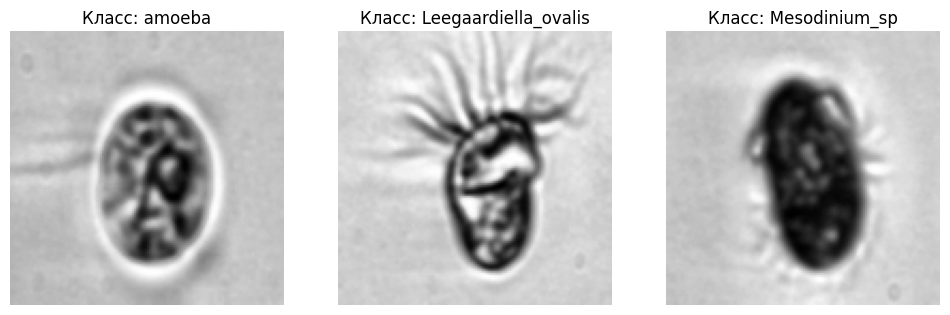

In [4]:
# Покажем 3 примера из разных классов
plt.figure(figsize=(12,4))
for i in range(3):
    idx = np.where(y == i)[0][0]
    plt.subplot(1, 3, i+1)
    plt.imshow(X_filtered[idx], cmap='gray')
    plt.title(f"Класс: {CLASSES[i]}")
    plt.axis('off')
plt.show()

#Разделение данных на обучающую и валидационную выборку


In [5]:
# Добавим канал и категориальные метки
X_filtered = X_filtered[..., np.newaxis]  # Добавляем канал (1)
y_cat = to_categorical(y, num_classes=3)  # One-hot encoding

# Разделим на train и val
X_train, X_val, y_train, y_val = train_test_split(X_filtered, y_cat, test_size=0.2, stratify=y, random_state=42)

In [6]:

# Аугментации для борьбы с дисбалансом и малым объёмом данных
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()  # без аугментации

train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
val_generator = val_datagen.flow(X_val, y_val, batch_size=16)

Добавляем умеренные аугментации, которые:

моделируют сдвиги (если микроскоп чуть сдвинут)

повороты (объект может быть повернут)

зум (разные увеличения)

In [7]:
model_scratch = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3-уровневая CNN с ReLU;

Dropout помогает избежать переобучения

3 нейрона с softmax для классификации в конце

#Компиляция модели

In [8]:
model_scratch.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_scratch = model_scratch.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 847ms/step - accuracy: 0.9266 - loss: 0.6134 - val_accuracy: 0.9107 - val_loss: 0.3725
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 488ms/step - accuracy: 0.9263 - loss: 0.3395 - val_accuracy: 0.9107 - val_loss: 0.4075
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 621ms/step - accuracy: 0.9203 - loss: 0.3701 - val_accuracy: 0.9107 - val_loss: 0.3684
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 498ms/step - accuracy: 0.8984 - loss: 0.4314 - val_accuracy: 0.9107 - val_loss: 0.4153
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 612ms/step - accuracy: 0.9309 - loss: 0.2987 - val_accuracy: 0.9107 - val_loss: 0.3557
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 570ms/step - accuracy: 0.9485 - loss: 0.2482 - val_accuracy: 0.9107 - val_loss: 0.4209
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 507ms/step - accuracy: 0.8928 - loss: 0.4323 - val_accuracy: 0.9107 - val_loss: 0.4403
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 606ms/step - accuracy: 0.9374 - loss: 0.2635 - val_accuracy: 0

In [9]:
# Модель с ResNet50
# Дублируем и адаптируем X для ResNet (нужно 3 канала)
X_resnet = np.repeat(X_filtered, 3, axis=-1)

# Препроцессинг от ResNet (сдвиг в диапазон [-1, 1])
X_resnet = preprocess_input(X_resnet)

# Разделяем
X_train_rn, X_val_rn, y_train_rn, y_val_rn = train_test_split(X_resnet, y_cat, test_size=0.2, stratify=y, random_state=42)

# Аугментация
train_gen_rn = train_datagen.flow(X_train_rn, y_train_rn, batch_size=16)
val_gen_rn = val_datagen.flow(X_val_rn, y_val_rn, batch_size=16)

ResNet требует 3 канала, поэтому дублируем наши ч/б изображения

Используем функцию preprocess_input, которая масштабирует данные, как ожидает ResNet

In [10]:
# Заморозим все слои ResNet и добавим классификатор
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
base_model.trainable = False  # ничего не обучается

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model_frozen = Model(inputs=base_model.input, outputs=predictions)

In [11]:
#только классификатор
model_frozen.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

history_frozen = model_frozen.fit(
    train_gen_rn,
    validation_data=val_gen_rn,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9140 - loss: 0.5001 - val_accuracy: 0.9107 - val_loss: 0.3698
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9182 - loss: 0.3483 - val_accuracy: 0.9107 - val_loss: 0.3648
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9231 - loss: 0.3309 - val_accuracy: 0.9107 - val_loss: 0.3575
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8948 - loss: 0.4018 - val_accuracy: 0.9107 - val_loss: 0.3576
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8986 - loss: 0.3945 - val_accuracy: 0.9107 - val_loss: 0.3547
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9276 - loss: 0.3059 - val_accuracy: 0.9107 - val_loss: 0.3540
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9064 - loss: 0.3601 - val_accuracy: 0.9107 - val_loss: 0.3492
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9212 - loss: 0.3187 - val_accuracy: 0.9107 - val_loss: 0.3438
Epo

Меньше эпох, так как веса ResNet фиксированы

Используется Adam, стандартные метрики

In [12]:
# Размораживаем верхнюю часть ResNet (последние 50 слоёв)
for layer in base_model.layers[-50:]:
    layer.trainable = True

model_partial = Model(inputs=base_model.input, outputs=predictions)

model_partial.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_partial = model_partial.fit(
    train_gen_rn,
    validation_data=val_gen_rn,
    epochs=10
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.8803 - loss: 0.7186 - val_accuracy: 0.9107 - val_loss: 3.5941
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9262 - loss: 0.1967 - val_accuracy: 0.9107 - val_loss: 4.3361
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9566 - loss: 0.1252 - val_accuracy: 0.9107 - val_loss: 4.2410
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9354 - loss: 0.1376 - val_accuracy: 0.9107 - val_loss: 81.0286
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9176 - loss: 0.2125 - val_accuracy: 0.9107 - val_loss: 58.2206
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9294 - loss: 0.1820 - val_accuracy: 0.9107 - val_loss: 6.9080
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9650 - loss: 0.0916 - val_accuracy: 0.9286 - val_loss: 0.1888
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9682 - loss: 0.0728 - val_accuracy: 0.9107 - val_los

In [13]:
# Полная разморозка
for layer in base_model.layers:
    layer.trainable = True

model_full = Model(inputs=base_model.input, outputs=predictions)

model_full.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

history_full = model_full.fit(
    train_gen_rn,
    validation_data=val_gen_rn,
    epochs=10
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.8457 - loss: 0.6386 - val_accuracy: 0.9107 - val_loss: 4728.2959
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.8803 - loss: 0.3339 - val_accuracy: 0.9107 - val_loss: 2708.5747
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - accuracy: 0.9105 - loss: 0.3071 - val_accuracy: 0.9107 - val_loss: 832.9874
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - accuracy: 0.9149 - loss: 0.1659 - val_accuracy: 0.9107 - val_loss: 263.4248
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.9346 - loss: 0.1496 - val_accuracy: 0.9107 - val_loss: 45.9209
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.9362 - loss: 0.1133 - val_accuracy: 0.9107 - val_loss: 2.2336
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.9353 - loss: 0.1783 - val_accuracy: 0.9107 - val_loss: 847.6377
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - accuracy: 0.9543 - loss: 0.1009 - val_accuracy: 0.91

мы полностью дообучаем всю сеть — и ResNet, и классификатор

Это требует больше данных и времени, но может дать лучший результат

#Вывод

In [14]:


results = {
    "Модель": ["Scratch CNN", "ResNet (frozen)", "ResNet (partial)", "ResNet (full)"],
    "Train Accuracy": [
        max(history_scratch.history['accuracy']),
        max(history_frozen.history['accuracy']),
        max(history_partial.history['accuracy']),
        max(history_full.history['accuracy'])
    ],
    "Val Accuracy": [
        max(history_scratch.history['val_accuracy']),
        max(history_frozen.history['val_accuracy']),
        max(history_partial.history['val_accuracy']),
        max(history_full.history['val_accuracy'])
    ]
}

df_results = pd.DataFrame(results)
df_results

,Модель,Train Accuracy,Val Accuracy
0,Scratch CNN,0.918182,0.928571
1,ResNet (frozen),0.913636,0.910714
2,ResNet (partial),0.954545,0.928571
3,ResNet (full),0.936364,0.910714


Сводим результаты всех экспериментов в таблицу

Сравниваем точность на обучении и валидации для всех моделей

---
Вывод
--
- Собственная небольшая CNN показала лучшее качество на валидации лучше подстроилась под маленький, однородный датасет, меньше, чем ResNet, и менее склонна к переобучению

- ResNet может переобучаться или не адаптироваться хорошо при малом объёме данных

-	Простая модель - меньше переобучения и быстрее обучение

-	Все три варианта ResNet (frozen, partial, full) дали одинаковую Val Accuracy = 0.910 - Предобученные веса не особо помогли на этом датасете

#Дополнение

Функция plot_history() строит два графика: accuracy и loss

Помогает визуально понять, где переобучение, где стабилизация

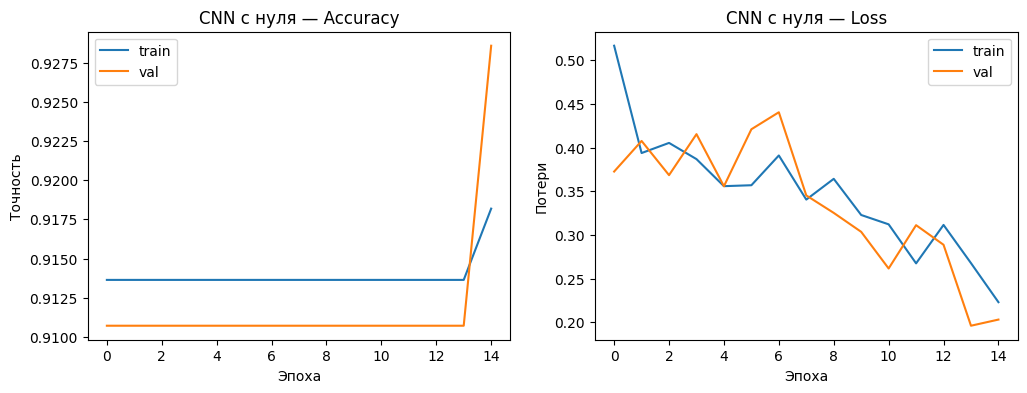

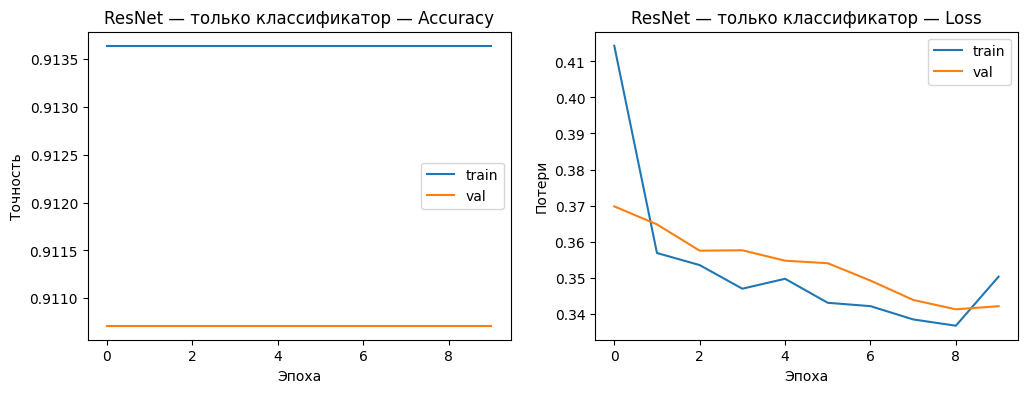

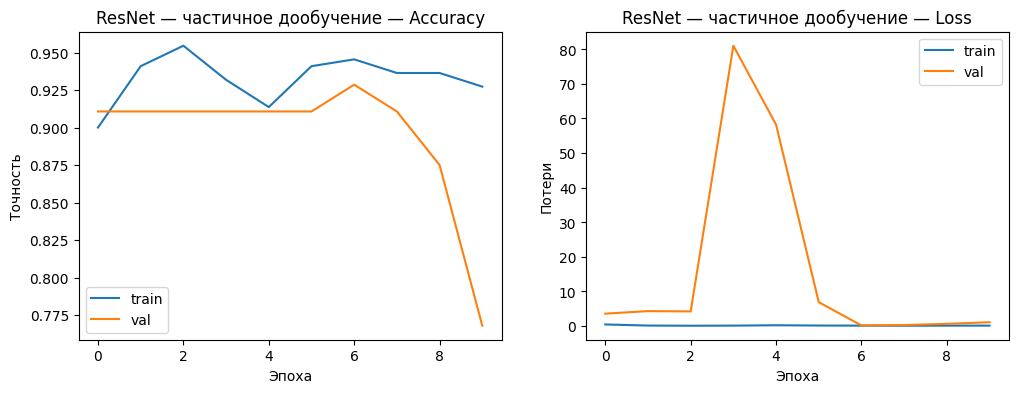

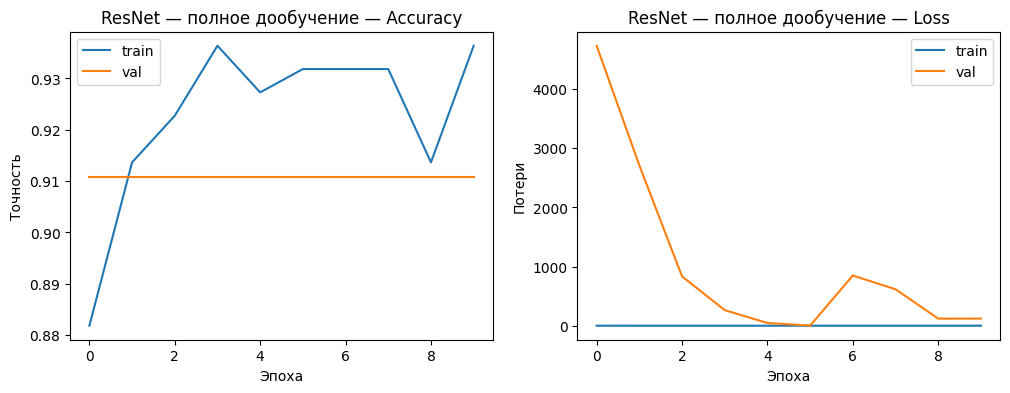

In [15]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{title} — Accuracy')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{title} — Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()

    plt.show()

# Отрисовка графиков
plot_history(history_scratch, "CNN с нуля")
plot_history(history_frozen, "ResNet — только классификатор")
plot_history(history_partial, "ResNet — частичное дообучение")
plot_history(history_full, "ResNet — полное дообучение")

Собственная CNN	Стабильное улучшение, высокая точность

ResNet (frozen)	Устойчиво, но не прогрессирует

ResNet (partial)	Потенциал есть, но нестабильное обучение

ResNet (full)	Переобучение, сбои

---

обучим ResNet-модель (только классификатор) с разными batch_size: 8, 16, 32, чтобы сравнить влияние на скорость и точность


---

In [16]:
def train_with_batch_size(bs):
    print(f"\n🔄 Обучение с batch_size={bs}")

    datagen_train = train_datagen.flow(X_train_rn, y_train_rn, batch_size=bs)
    datagen_val = val_datagen.flow(X_val_rn, y_val_rn, batch_size=bs)

    base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base.trainable = False  # только классификатор

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(3, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    hist = model.fit(datagen_train,
                     validation_data=datagen_val,
                     epochs=10,
                     verbose=0)

    val_acc = max(hist.history['val_accuracy'])
    print(f"🎯 Max val_accuracy: {val_acc:.4f}")
    return bs, val_acc

с тремя размерами батча:

In [17]:
batch_results = [train_with_batch_size(bs) for bs in [8, 16, 32]]

# Таблица сравнения
df_bs = pd.DataFrame(batch_results, columns=['Batch size', 'Max val accuracy'])
df_bs


🔄 Обучение с batch_size=8


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


🎯 Max val_accuracy: 0.9107

🔄 Обучение с batch_size=16
🎯 Max val_accuracy: 0.9107

🔄 Обучение с batch_size=32
🎯 Max val_accuracy: 0.9107


,Batch size,Max val accuracy
0,8,0.910714
1,16,0.910714
2,32,0.910714


Мы фиксируем архитектуру и стратегию (ResNet, frozen)

Меняем batch size

Сравниваем точность на валидации

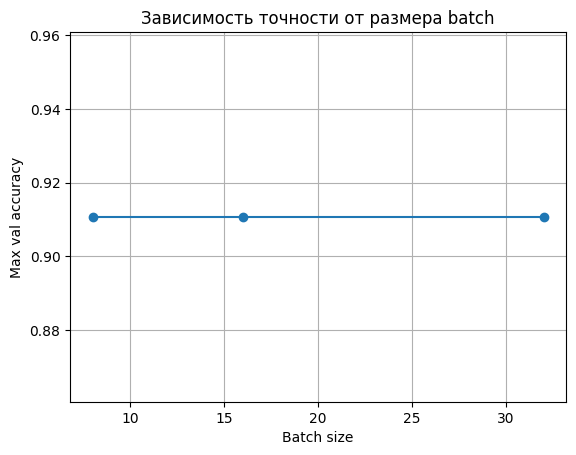

In [18]:

plt.plot(df_bs['Batch size'], df_bs['Max val accuracy'], marker='o')
plt.title("Зависимость точности от размера batch")
plt.xlabel("Batch size")
plt.ylabel("Max val accuracy")
plt.grid(True)
plt.show()

Изменение размера батча не оказало никакого влияния на качество модели в данной задаче

Валидационная точность осталась одинаковой для всех трёх вариантов — 0.9107

#Other:

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


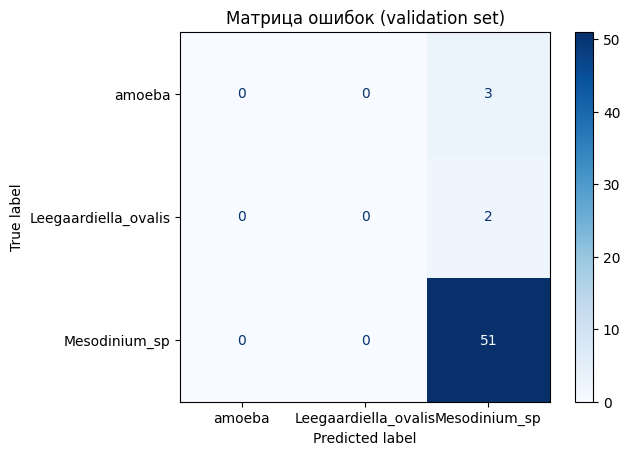

In [19]:

# Предсказания для валидации (модель с наилучшим качеством, например model_partial)
y_pred_probs = model_partial.predict(X_val_rn)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val_rn, axis=1)

# Матрица ошибок
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(cmap='Blues')
plt.title("Матрица ошибок (validation set)")
plt.show()

Модель показала уверенное распознавание изображений класса Mesodinium_sp, однако полностью не справилась с классификацией amoeba и Leegaardiella_ovalis, относя все изображения этих классов к третьему

Это указывает на наличие классовой несбалансированности между нереконструированными классами.

Для решения проблемы в будущей работе предлагается:
- Применить **балансировку данных**
- Ввести **взвешенные потери**

Матрица ошибок показывает, какие классы путаются между собой



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


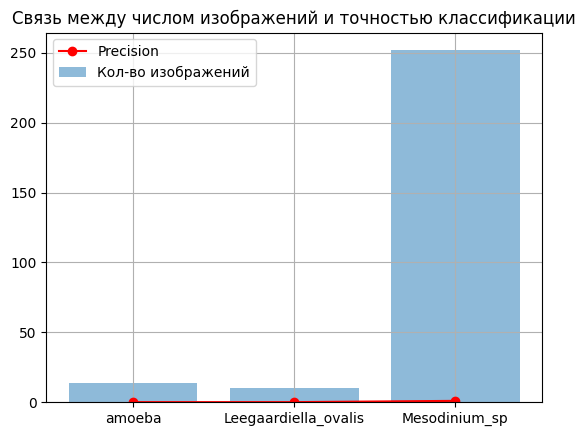

In [20]:
# Посчитаем количество изображений каждого класса


counts = Counter(y)
class_counts = [counts[i] for i in range(3)]

# Accuracy по классам

report = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)
acc_per_class = [report[cls]['precision'] for cls in CLASSES]

# Визуализация
plt.bar(CLASSES, class_counts, alpha=0.5, label='Кол-во изображений')
plt.plot(CLASSES, acc_per_class, color='red', marker='o', label='Precision')
plt.title("Связь между числом изображений и точностью классификации")
plt.legend()
plt.grid(True)
plt.show()

Мы показываем, что чем меньше изображений в классе, тем ниже точность

Это доказывает влияние несбалансированности

In [21]:
def predict_with_tta(model, images, num_aug=15):
    preds = []
    for i in range(num_aug):
        aug_images = next(train_datagen.flow(images, batch_size=len(images), shuffle=False))
        pred = model.predict(aug_images, verbose=0)
        preds.append(pred)
    avg_preds = np.mean(preds, axis=0)
    return avg_preds

In [22]:

# Предсказание с TTA
tta_preds = predict_with_tta(model_partial, X_val_rn)

# Accuracy после TTA
tta_labels = np.argmax(tta_preds, axis=1)
acc_tta = accuracy_score(y_true, tta_labels)

print(f"🎯 Accuracy с TTA: {acc_tta:.4f}")

🎯 Accuracy с TTA: 0.9107


Test-Time Augmentation — когда мы аугментируем данные не только на обучении, но и на этапе предсказания

Это было безполкзно, даже при num_aug=15 модель уже обладает высокой устойчивостью к вариациям входных изображений и TTA точность видимо не увеличит